**Name: Mayuresh Rajesh Dindorkar**  
**Roll No.: CS23MTECH14007**  
**Deep Learning Assignment No. 4**  

---
**Importing the libraries:**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---
**Utility functions:**

In [3]:
def show_image(img, title):
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [4]:
def plot_loss_plot(title, loss_list, epochs):
    plt.plot(np.arange(1, epochs + 1), loss_list, label='Latent Dim 32')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title(title)
    plt.show()

In [5]:
def train_model(model, epochs, optimizer, loss_function, train_loader):
    epoch_loss_list = []
    epoch = 1
    no_of_batches = len(train_loader)
    while epoch <= epochs:
        batch_loss = []
        for batch_of_imgs, _ in train_loader:
            batch_of_imgs = batch_of_imgs.to(device)
            optimizer.zero_grad()
            reconstructed_batch_of_imgs = model(batch_of_imgs)
            batch_size = batch_of_imgs.shape[0]
            loss = loss_function(reconstructed_batch_of_imgs, batch_of_imgs.view(batch_size, -1))
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        epoch_loss_list.append(sum(batch_loss) / no_of_batches)
        print('Epoch:', epoch, ', Loss:', epoch_loss_list[-1])
        epoch = epoch + 1
    return epoch_loss_list

In [6]:
def calculate_reconstruction_error(model, loss_function, dataset_loader):
    loss_value = 0
    no_of_batches = len(dataset_loader)
    for batch_of_imgs, _ in dataset_loader:
        batch_of_imgs = batch_of_imgs.to(device)
        reconstructed_batch_of_imgs = model(batch_of_imgs)
        batchs_size = batch_of_imgs.shape[0]
        loss = loss_function(reconstructed_batch_of_imgs, batch_of_imgs.view(batchs_size, -1))
        loss_value = loss.item() + loss_value
    return loss_value / no_of_batches

In [7]:
def visualize_reconstructions(model, data_loader, num_of_reconstructions):
    images, labels = next(iter(data_loader))
    images = images.to(device)
    outputs = model(images)
    outputs = outputs.view(-1, 1, 28, 28)
    fig, axes = plt.subplots(2, num_of_reconstructions, figsize=(20, 6))
    fig.text(0, 0.8, 'Original Images:', ha='left', va='center', fontsize=12, fontweight='bold')    
    fig.text(0, 0.4, 'Reconstructed Images:', ha='left', va='center', fontsize=12, fontweight='bold')
    for i in range(0, num_of_reconstructions, 1):
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

In [8]:
def get_latent_points_by_interpolation(sample_1, sample_2, no_of_steps):
    step_size = (sample_2 - sample_1) / no_of_steps
    return [ i * step_size + sample_1 for i in range(0, no_of_steps, 1)]

In [9]:
def decode_latent_representation(ae, latent_representation):
    with torch.no_grad():
        reconstructed = ae.decoder(latent_representation)
    return reconstructed

In [10]:
def plot_reconstructions(sample_img_1, reconstructed_samples, sample_img_2):
    fig, axes = plt.subplots(2, 6, figsize=(12, 4))
    axes[0, 0].imshow(sample_img_1, cmap='gray')
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Sample 1')
    row, col = 0, 1
    for i, img in enumerate(reconstructed_samples):
        axes[row, col].imshow(img[0].cpu().squeeze(), cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title('Reconstructed Img:' + str(i+1))
        col = col + 1
        if col == 6:
            col = 0
            row = row + 1
    axes[1, 5].imshow(sample_img_2, cmap='gray')
    axes[1, 5].axis('off')
    axes[1, 5].set_title('Sample 2')
    plt.tight_layout()
    plt.show()

In [11]:
def plot_generated_images(generated_images):
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.axis('off')
        ax.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    plt.tight_layout()
    plt.show()

In [12]:
def train_vae_model(vae, epochs, optimizer, train_loader, loss_function_for_vae):
    vae.train()
    list_of_loss = []
    for epoch in range(1, epochs + 1, 1):
        batch_loss = []
        for batch_idx, (batch_of_images, _) in enumerate(train_loader):
            batch_of_images = batch_of_images.to(device)
            optimizer.zero_grad()
            
            reconstructed_batch, mean, log_var = vae(batch_of_images)
            loss = loss_function_for_vae(reconstructed_input = reconstructed_batch, mean = mean, input = batch_of_images, log_var = log_var)
            
            loss.backward()
            batch_loss.append(loss.item())
            optimizer.step()
        list_of_loss.append(sum(batch_loss) / len(train_loader.dataset))
        print('Epoch:', epoch, 'Loss:', list_of_loss[-1])
    return list_of_loss

---
**Importing the dataset:**

In [13]:
trainset = torchvision.datasets.MNIST(root='./data', download=True, train=True, 
                                      transform=transforms.Compose([transforms.ToTensor()]))
testset = torchvision.datasets.MNIST(root='./data', download=True, train=False, 
                                     transform=transforms.Compose([transforms.ToTensor()]))

In [14]:
train_loader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=32)
test_loader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=32)
loader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=32)

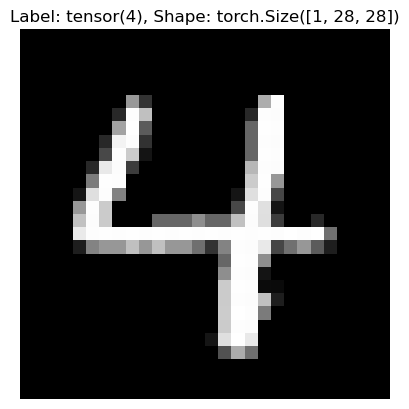

In [15]:
train_iterator = iter(train_loader)
batch_of_imgs, batch_of_labels = next(train_iterator)
show_image(batch_of_imgs[0], 'Label: ' + str(batch_of_labels[0]) + ', Shape: ' + str(batch_of_imgs[0].shape))

---
---

**Question 1: Autoencoder**

In [16]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Autoencoder, self).__init__()
        self.initialize_parameters(latent_dimension)
        self.initialize_ae_layers()

    def initialize_parameters(self, latent_dimension):
        self.input_dimension = 28*28
        self.latent_dimension = latent_dimension

    def initialize_ae_layers(self):
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dimension, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, self.latent_dimension),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dimension, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, self.input_dimension),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.decoder(self.encoder(x))

Epoch: 1 , Loss: 0.030878885757923125
Epoch: 2 , Loss: 0.02194140933106343
Epoch: 3 , Loss: 0.020562412795921168
Epoch: 4 , Loss: 0.01979573576549689
Epoch: 5 , Loss: 0.019101827440659205
Epoch: 6 , Loss: 0.018662619259456795
Epoch: 7 , Loss: 0.018335437654952207
Epoch: 8 , Loss: 0.01811091047078371
Epoch: 9 , Loss: 0.01791848558237155
Epoch: 10 , Loss: 0.017688025064766407


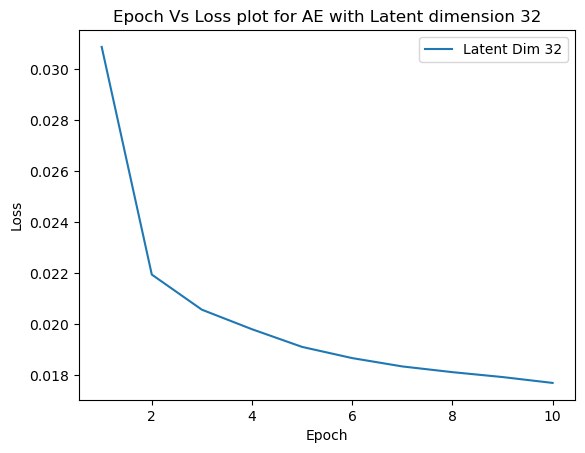

AE with Latent Dimension 32: Train Reconstruction Error: 0.01735794683198134, Test Recon Error: 0.017901162108102928


In [17]:
ae_32 = Autoencoder(latent_dimension = 32).to(device)
epochs = 10
epoch_loss_list_32 = train_model(model = ae_32, loss_function = nn.MSELoss(), epochs = epochs, 
                  optimizer = optim.Adam(ae_32.parameters(), lr=0.001), train_loader = train_loader)
plot_loss_plot('Epoch Vs Loss plot for AE with Latent dimension 32', epoch_loss_list_32, epochs = epochs)

train_reconstruction_error_32 = calculate_reconstruction_error(model = ae_32, loss_function = nn.MSELoss(), dataset_loader = train_loader)
test_reconstruction_error_32  = calculate_reconstruction_error(model = ae_32, loss_function = nn.MSELoss(), dataset_loader = test_loader)
print('AE with Latent Dimension 32: Train Reconstruction Error: {}, Test Recon Error: {}'.format(train_reconstruction_error_32, test_reconstruction_error_32))

Epoch: 1 , Loss: 0.029471628458797933
Epoch: 2 , Loss: 0.018445419180889926
Epoch: 3 , Loss: 0.016624592341482638
Epoch: 4 , Loss: 0.015861449939012527
Epoch: 5 , Loss: 0.015330309056739013
Epoch: 6 , Loss: 0.014650746176143488
Epoch: 7 , Loss: 0.01430009780973196
Epoch: 8 , Loss: 0.014031827463706334
Epoch: 9 , Loss: 0.013855077389876048
Epoch: 10 , Loss: 0.01369284519404173


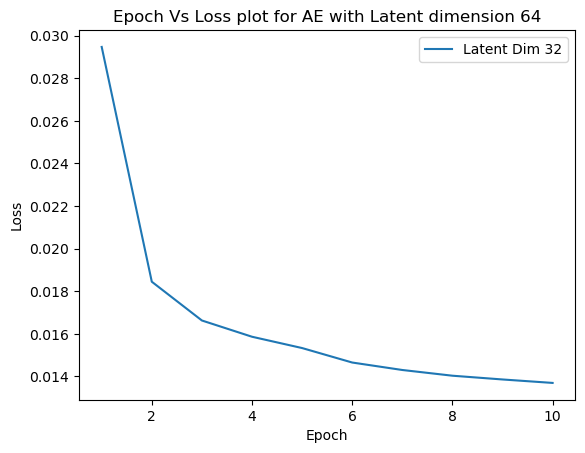

AE with Latent Dimension 64: Train Reconstruction Error: 0.013531860409677028, Test Recon Error: 0.013713641202273651


In [18]:
ae_64 = Autoencoder(latent_dimension = 64).to(device)
epoch_loss_list_64 = train_model(model = ae_64, loss_function = nn.MSELoss(), epochs = 10, 
                  optimizer = optim.Adam(ae_64.parameters(), lr=0.001), train_loader = train_loader)
plot_loss_plot('Epoch Vs Loss plot for AE with Latent dimension 64', epoch_loss_list_64, epochs = epochs)

train_reconstruction_error_64 = calculate_reconstruction_error(model = ae_64, loss_function = nn.MSELoss(), dataset_loader = train_loader)
test_reconstruction_error_64  = calculate_reconstruction_error(model = ae_64, loss_function = nn.MSELoss(), dataset_loader = test_loader)
print('AE with Latent Dimension 64: Train Reconstruction Error: {}, Test Recon Error: {}'.format(train_reconstruction_error_64, test_reconstruction_error_64))

Epoch: 1 , Loss: 0.028978036603331567
Epoch: 2 , Loss: 0.01791188746591409
Epoch: 3 , Loss: 0.016164951178928216
Epoch: 4 , Loss: 0.015190450952947139
Epoch: 5 , Loss: 0.014604197062551975
Epoch: 6 , Loss: 0.01416049600293239
Epoch: 7 , Loss: 0.01382126640677452
Epoch: 8 , Loss: 0.013533854434887568
Epoch: 9 , Loss: 0.013286738114058972
Epoch: 10 , Loss: 0.013060600053767362


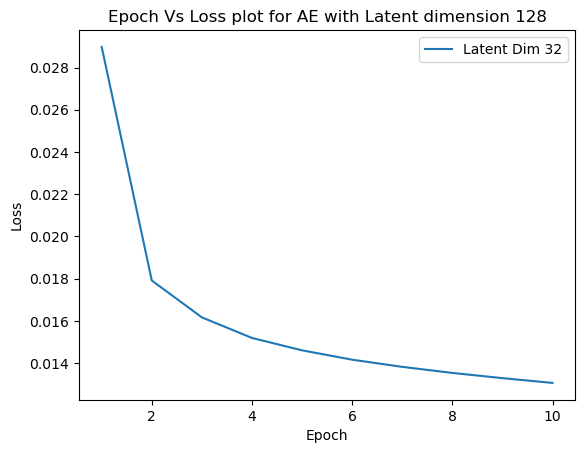

AE with Latent Dimension 128: Train Reconstruction Error: 0.012856094007194042, Test Recon Error: 0.013073560716316532


In [19]:
ae_128 = Autoencoder(latent_dimension = 128).to(device)
epoch_loss_list_128 = train_model(model = ae_128, loss_function = nn.MSELoss(), epochs = 10, 
                  optimizer = optim.Adam(ae_128.parameters(), lr=0.001), train_loader = train_loader)
plot_loss_plot('Epoch Vs Loss plot for AE with Latent dimension 128', epoch_loss_list_128, epochs = epochs)

train_reconstruction_error_128 = calculate_reconstruction_error(model = ae_128, loss_function = nn.MSELoss(), dataset_loader = train_loader)
test_reconstruction_error_128  = calculate_reconstruction_error(model = ae_128, loss_function = nn.MSELoss(), dataset_loader = test_loader)
print('AE with Latent Dimension 128: Train Reconstruction Error: {}, Test Recon Error: {}'.format(train_reconstruction_error_128, test_reconstruction_error_128))

**(a) Recontruction Error Comparison:**  
 - We can observe that, as the latent dimension increases, the reconstruction error decreases.

| Autoencoder Latent Dimension | Train Reconstruction Error | Test Reconstruction Error |
| :--------------------------: | :------------------------: | :-----------------------: |
|              32              |           0.0173           |          0.0179           |
|              64              |           0.0135           |          0.0137           |
|             128              |           0.0128           |          0.0130           |  |
 |
   |


---
### **Visualizing the reconstructions:**

**Reconstruction by Autoencoder with latent dimension of 32:**  
**Train set:**

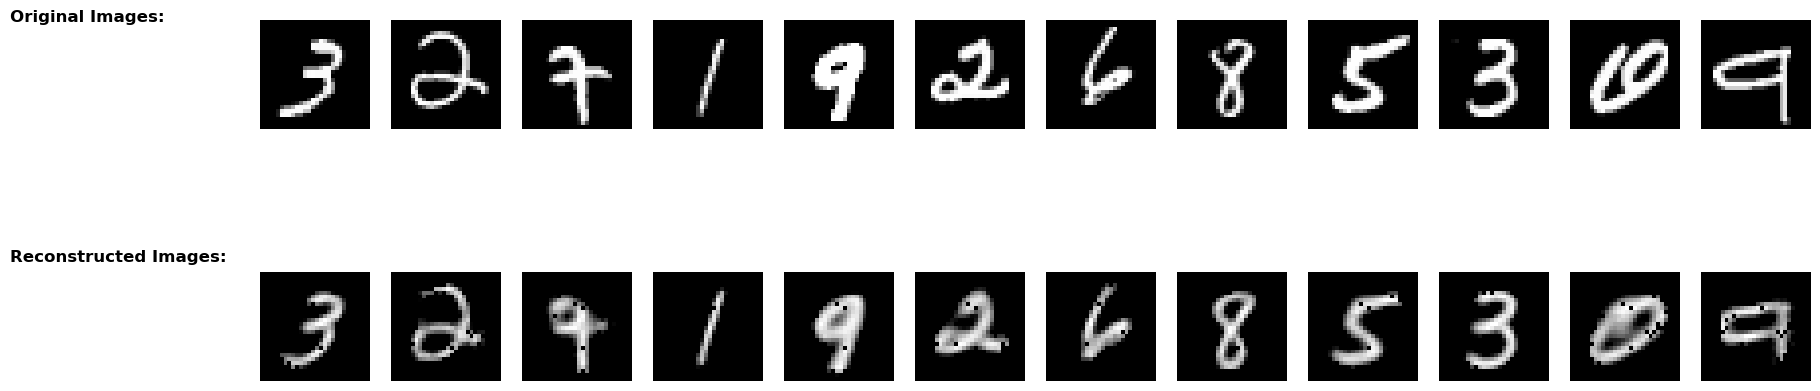

In [20]:
visualize_reconstructions(model = ae_32, data_loader = train_loader, num_of_reconstructions = 12)

**Test set:**

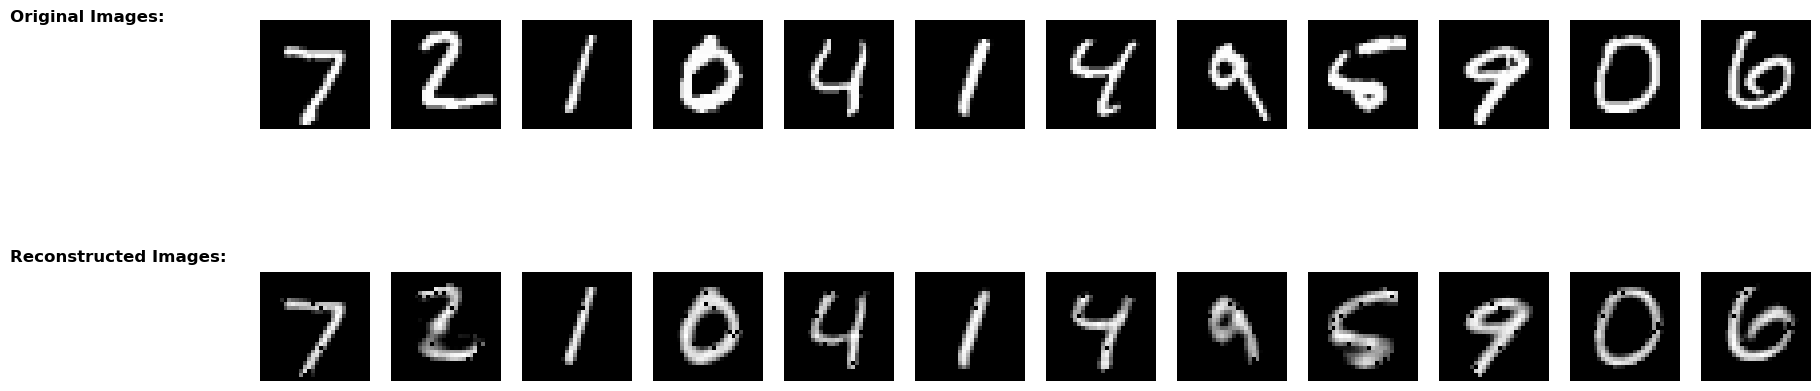

In [21]:
visualize_reconstructions(model = ae_32, data_loader = test_loader, num_of_reconstructions = 12)

---
**Reconstruction by Autoencoder with latent dimension of 64:**  
**Train set:**

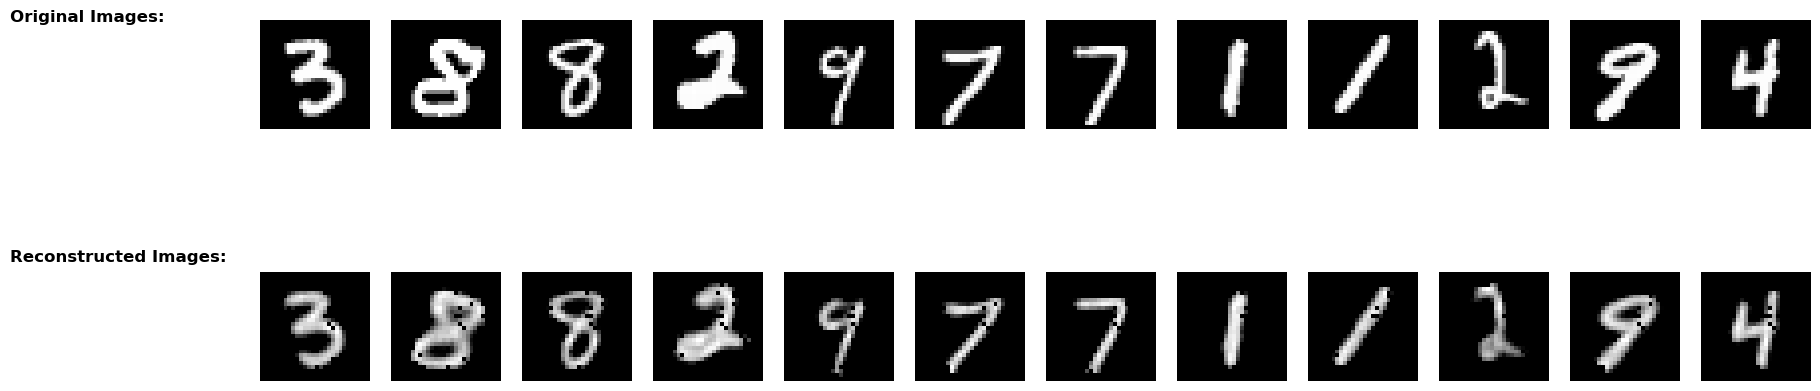

In [22]:
visualize_reconstructions(model = ae_64, data_loader = train_loader, num_of_reconstructions = 12)

**Test set:**

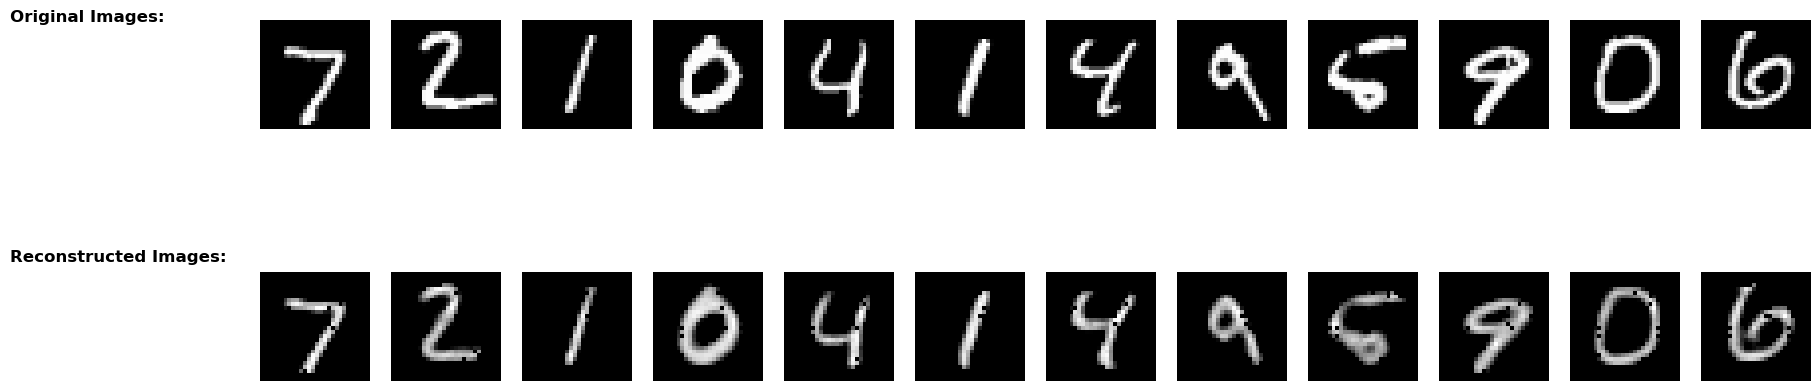

In [23]:
visualize_reconstructions(model = ae_64, data_loader = test_loader, num_of_reconstructions = 12)

---
**Reconstruction by Autoencoder with latent dimension of 128:**  
**Train set:**

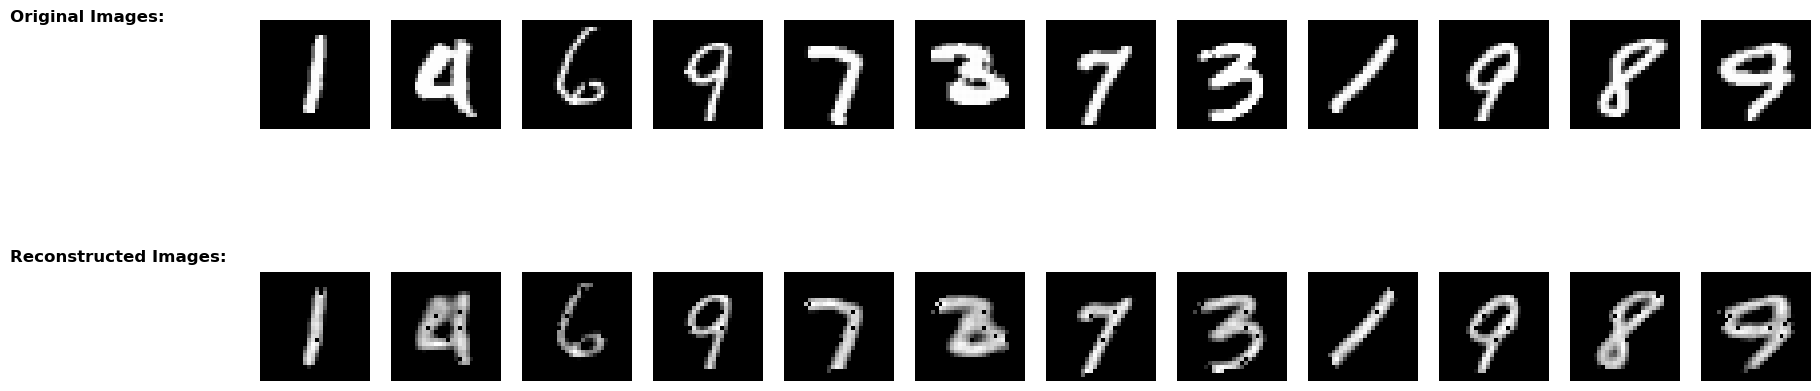

In [24]:
visualize_reconstructions(model = ae_128, data_loader = train_loader, num_of_reconstructions = 12)

**Test set:**

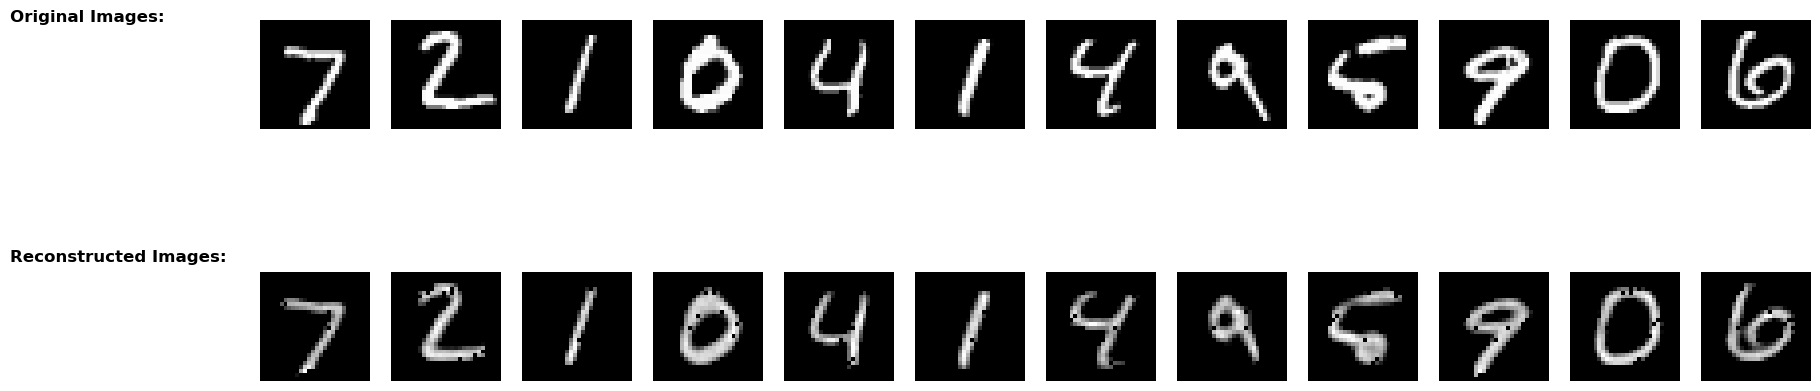

In [25]:
visualize_reconstructions(model = ae_128, data_loader = test_loader, num_of_reconstructions = 12)

---
**(b) Reconstruction on the line joining two training data samples in the hidden space:**

In [26]:
def reconstruction_between_two_samples(model, no_of_steps, loader):
    dataset_iterator = iter(loader)
    batch_of_imgs, _ = next(dataset_iterator)
    sample_img_1 = batch_of_imgs[0]
    sample_img_1 = sample_img_1.to(device)
    sample_img_2 = batch_of_imgs[1]
    sample_img_2 = sample_img_2.to(device)

    encoded_sample2 = model.encoder(sample_img_2.view(sample_img_2.size(0), -1))
    encoded_sample1 = model.encoder(sample_img_1.view(sample_img_1.size(0), -1))

    interpolated_latent_samples = get_latent_points_by_interpolation(encoded_sample1, encoded_sample2, no_of_steps = no_of_steps)
    reconstructed_samples = []
    for latent_sample in interpolated_latent_samples:
        reconstructed_sample = decode_latent_representation(model, latent_sample)
        reconstructed_samples.append(reconstructed_sample.view(-1, 1, 28, 28))
    plot_reconstructions(sample_img_1 = sample_img_1.cpu().squeeze(), sample_img_2 = sample_img_2.cpu().squeeze(), reconstructed_samples = reconstructed_samples)

**Reconstruction between pair 1 of samples:**

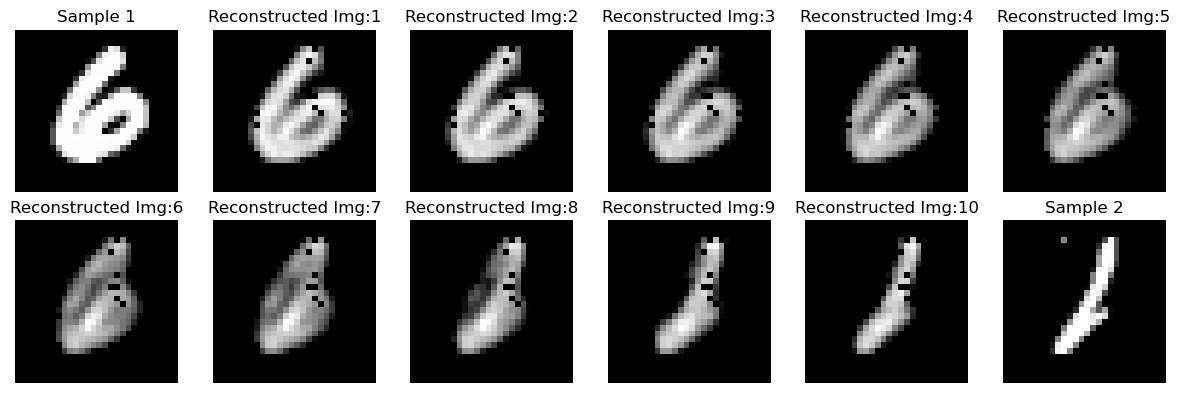

In [27]:
reconstruction_between_two_samples(model = ae_64, no_of_steps = 10, loader = loader)

**Reconstruction between pair 2 of samples:**

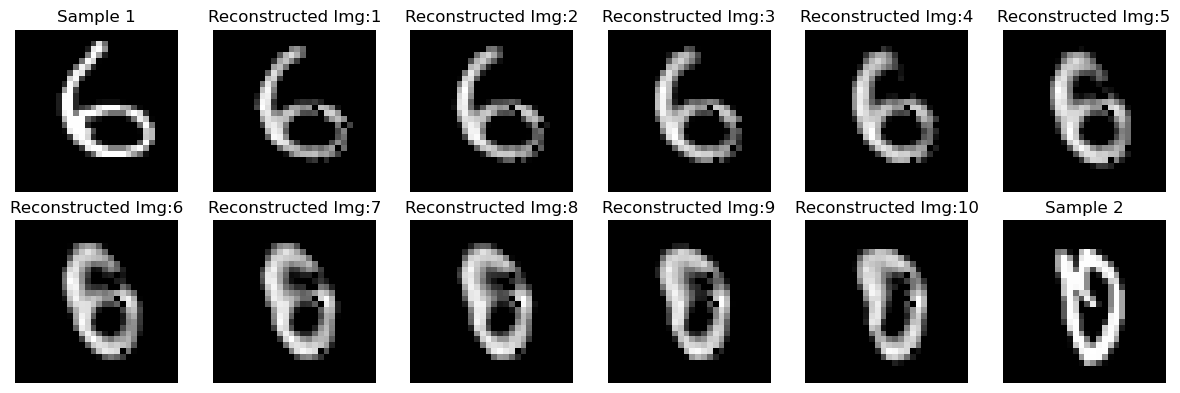

In [28]:
reconstruction_between_two_samples(model = ae_64, no_of_steps = 10, loader = loader)

**Reconstruction between pair 3 of samples:**

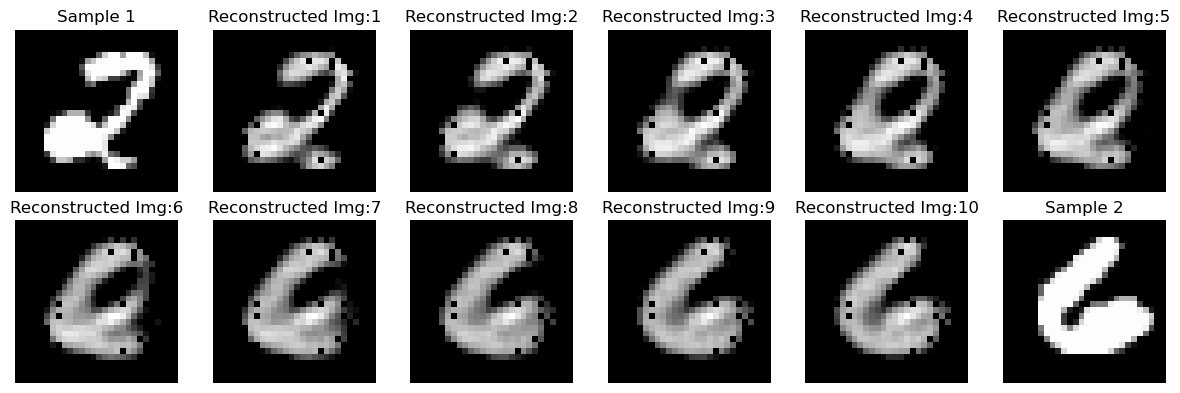

In [29]:
reconstruction_between_two_samples(model = ae_64, no_of_steps = 10, loader = loader)

**Reconstruction between pair 4 of samples:**

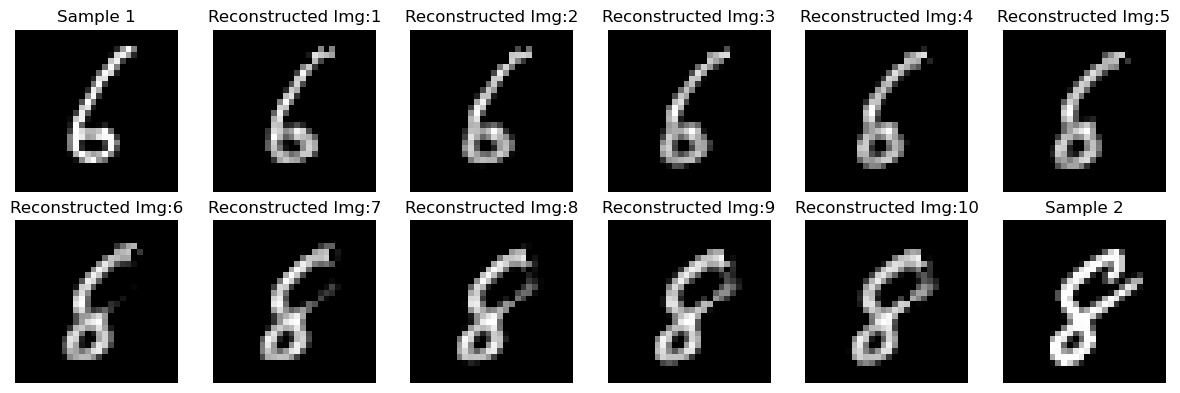

In [36]:
reconstruction_between_two_samples(model = ae_64, no_of_steps = 10, loader = loader)

**Reconstruction between pair 5 of samples:**

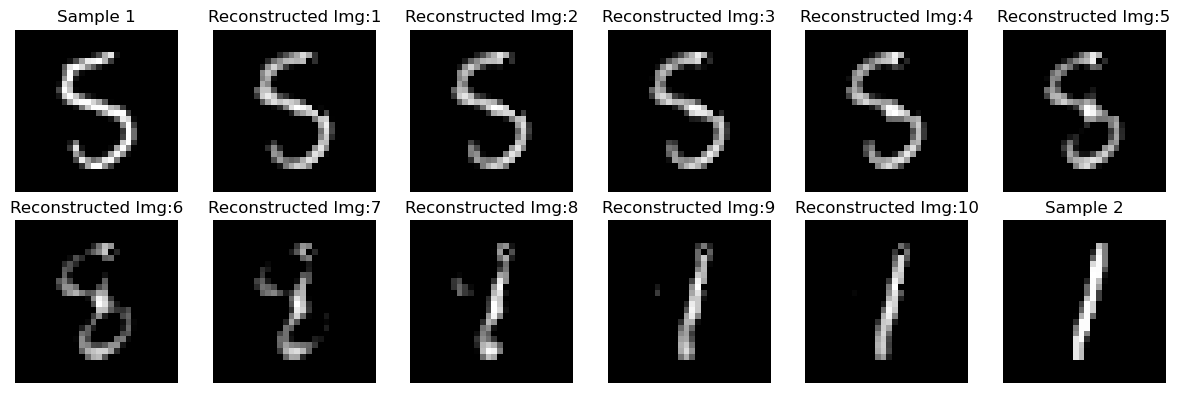

In [37]:
reconstruction_between_two_samples(model = ae_64, no_of_steps = 10, loader = loader)

---
---
**Question 2: Variational Autoencoder**

In [32]:
class VAE(nn.Module):
    def __init__(self, latent_dimension):
        super(VAE, self).__init__()
        self.initialize_vae_params(latent_dimension)
        self.initialize_layers()

    def initialize_vae_params(self, latent_dimension):
        self.input_dimension = 28*28
        self.latent_dimension = latent_dimension

    def initialize_layers(self):
        self.dense_layer_1 = nn.Linear(self.input_dimension, 500)
        self.dense_layer_2 = nn.Linear(500, 250)
        
        self.mean = nn.Linear(250, self.latent_dimension)
        self.log_var = nn.Linear(250, self.latent_dimension)
        
        self.dense_layer_4 = nn.Linear(self.latent_dimension, 250)
        self.dense_layer_5 = nn.Linear(250, 500)
        self.dense_layer_6 = nn.Linear(500, self.input_dimension)

    def encode(self, x):
        x = torch.relu(self.dense_layer_2(torch.relu(self.dense_layer_1(x))))
        return self.mean(x), self.log_var(x)

    def reparameterization_trick(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        std = std.to(device)
        eps = torch.randn_like(std)
        eps = eps.to(device)
        return mu + eps*std

    def decode(self, z):
        z = torch.relu(self.dense_layer_5(torch.relu(self.dense_layer_4(z))))
        return torch.sigmoid(self.dense_layer_6(z))

    def forward(self, x):
        mean, log_var = self.encode(x.view(-1, 784))
        return self.decode(self.reparameterization_trick(mean, log_var).to(device)), mean, log_var

def loss_function_for_vae(input, reconstructed_input, mean, log_var):
    KL_divergence = -0.5 * torch.sum(1 + log_var - mean ** 2 - log_var.exp())
    return F.binary_cross_entropy(reconstructed_input, input.view(-1, 784), reduction='sum') + KL_divergence

Epoch: 1 Loss: 141.93890996907552
Epoch: 2 Loss: 115.4559892537435
Epoch: 3 Loss: 110.53558127034505
Epoch: 4 Loss: 108.09305739746094
Epoch: 5 Loss: 106.59913277180989
Epoch: 6 Loss: 105.5731826944987
Epoch: 7 Loss: 104.75879571126302
Epoch: 8 Loss: 104.11125544026693
Epoch: 9 Loss: 103.53669431966146
Epoch: 10 Loss: 103.20854565429687
Epoch: 11 Loss: 102.75479184977213
Epoch: 12 Loss: 102.50137482910156
Epoch: 13 Loss: 102.1557906616211
Epoch: 14 Loss: 101.97431801757813
Epoch: 15 Loss: 101.68262157389323
Epoch: 16 Loss: 101.50852679443359
Epoch: 17 Loss: 101.26381649983723
Epoch: 18 Loss: 101.14084369710287
Epoch: 19 Loss: 100.9282187093099
Epoch: 20 Loss: 100.76279942626954


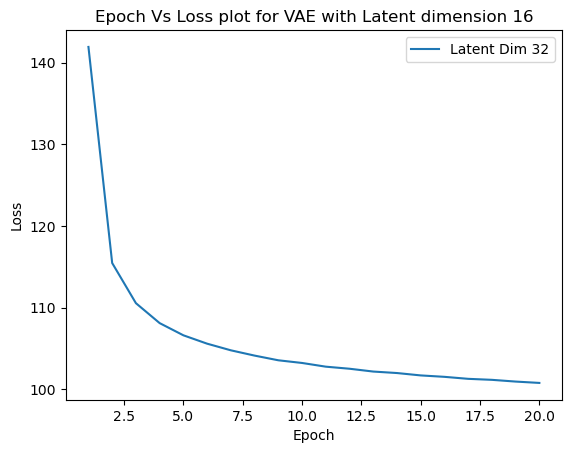

In [33]:
vae = VAE(latent_dimension = 16).to(device)
epochs = 20
list_of_loss_vae = train_vae_model(vae = vae, epochs = epochs, optimizer = optim.Adam(vae.parameters()), train_loader = train_loader, loss_function_for_vae = loss_function_for_vae)
plot_loss_plot('Epoch Vs Loss plot for VAE with Latent dimension 16', list_of_loss_vae, epochs = epochs)

**Generating 64 images using VAE:**

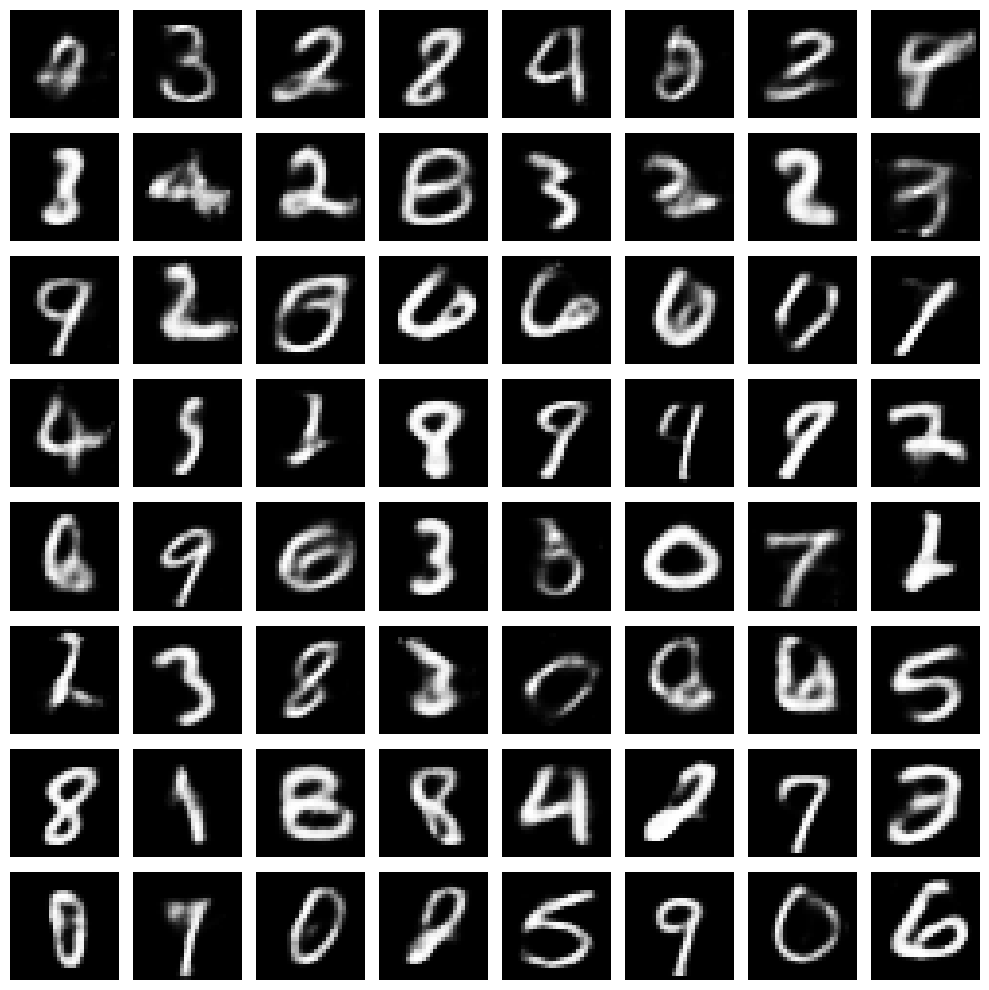

In [34]:
latent_dimension = 16
with torch.no_grad():
    z = torch.randn(64, latent_dimension)
    z = z.to(device)
    generated_images = vae.decode(z).cuda().view(-1, 1, 28, 28)
plot_generated_images(generated_images)

---